In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
# Carregando os dados e ajustando o datetime
tsla_data = pd.read_csv("data/TSLA.csv")
tsla_data["Date"] = pd.to_datetime(tsla_data["Date"])
tsla_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...,...
3556,2024-08-15,205.020004,215.880005,204.820007,214.139999,214.139999,89848500
3557,2024-08-16,211.149994,219.800003,210.800003,216.119995,216.119995,88765100
3558,2024-08-19,217.070007,222.979996,214.089996,222.720001,222.720001,76435200
3559,2024-08-20,224.880005,228.220001,219.559998,221.100006,221.100006,74001200


In [58]:
# Função para calcular a média móvel exponencial dos dados
def moving_average(data_column, date_column, size):
    # Número de dados
    n_of_data = data_column.size
    # Array para conter a média móvel
    moving_average = np.zeros((n_of_data - size + 1))

    # Primeira média móvel calculada como aritmética
    previous_mme = np.mean(data_column[0:size - 1])
    # Salvando a primeira média
    moving_average[0] = previous_mme

    # Multiplicador da fórmula
    alpha = 2/(size + 1)

    # Para cada média móvel...
    for i in range(1, n_of_data - size + 1):
        # Calcula a nova média
        new_mme = (data_column[size - 1 + i] - previous_mme) * alpha + previous_mme
        # Salva no array
        moving_average[i] = new_mme
        # Atualiza a anterior
        previous_mme = new_mme

    # Adiciona a data à série
    dated_average = pd.Series(moving_average, date_column[size - 1:])
    
    return dated_average

In [59]:
# Função do cruzamento de médias móveis
def ma_crossover(long_average, short_average):
    # Matriz com as duas médias lado a lado
    aux_matrix = np.hstack((long_average.values.reshape(-1, 1), short_average.values[short_average.size - long_average.size:].reshape(-1, 1)))
    
    # Vetor que analisa quando a média curta é maior que a longa
    bool_vector = aux_matrix[:, 1] > aux_matrix[:, 0]
    
    # Analisando quando a média curta cruza a longa
    bool_matrix = np.zeros((bool_vector.size + 1, 2))
    bool_matrix[1:, 0] = bool_vector
    bool_matrix[:-1, 1] = bool_vector
    evaluation = bool_matrix[1:-1, 1] - bool_matrix[1:-1, 0]
    evaluation = evaluation.astype(str)

    # Rotulando quando comprar, vender e manter
    evaluation[evaluation == "0.0"] = "keep"
    evaluation[evaluation == "1.0"] = "buy"
    evaluation[evaluation == "-1.0"] = "sell"

    # Adicionando a data à série
    dated_evaluations = pd.Series(evaluation, long_average.index[1:])

    return dated_evaluations

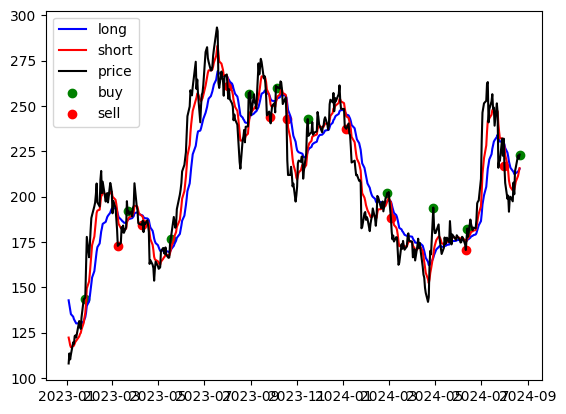

In [60]:
# Médias longa e curta
long_average = moving_average(tsla_data["Adj Close"], tsla_data["Date"], 21)
short_average = moving_average(tsla_data["Adj Close"], tsla_data["Date"], 8)
evaluations = ma_crossover(long_average, short_average)

start_date = "2023-01-01"
stop_date = "2024-01-01"

buys = evaluations[(evaluations.index > start_date) & (evaluations.values == "buy")].index
sells = evaluations[(evaluations.index > start_date) & (evaluations.values == "sell")].index

plt.plot(long_average[long_average.index > pd.to_datetime(start_date)], color = "blue", label = "long")
plt.plot(short_average[short_average.index > pd.to_datetime(start_date)], color = "red", label = "short")
plt.plot(pd.Series(tsla_data["Adj Close"][tsla_data["Date"] > pd.to_datetime(start_date)].values, tsla_data["Date"][tsla_data["Date"] > pd.to_datetime(start_date)]), color = "black", label = "price")
plt.scatter(buys, tsla_data[tsla_data["Date"].isin(buys)]["Adj Close"], color = "green", label = "buy")
plt.scatter(sells, tsla_data[tsla_data["Date"].isin(sells)]["Adj Close"], color = "red", label = "sell")
plt.legend()

In [61]:
buys.values
tsla_data[tsla_data["Date"].isin(buys)]["Adj Close"]

3164    143.889999
3205    192.220001
3244    176.889999
3315    256.899994
3340    260.049988
3369    242.839996
3439    202.039993
3481    194.050003
3513    182.470001
3560    223.270004
Name: Adj Close, dtype: float64